<a href="https://colab.research.google.com/github/schwamb/311-service-project/blob/main/311_service_request.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving 311_Service_Requests.csv to 311_Service_Requests.csv


In [ ]:
# Read the csv file into a pandas DataFrame
import io
service_requests_starter = pd.read_csv((io.BytesIO(uploaded['311_Service_Requests.csv'])))

index = service_requests_starter.index
number_of_rows = len(service_requests_starter) 
print(number_of_rows)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,18,28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


4314562


In [ ]:
import os
spark_version = 'spark-3.0.2'
os.environ['SPARK_VERSION']=spark_version
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [ ]:
service_requests_starter.head()

,SR_NUMBER,SR_TYPE,SR_SHORT_CODE,OWNER_DEPARTMENT,STATUS,CREATED_DATE,LAST_MODIFIED_DATE,CLOSED_DATE,STREET_ADDRESS,CITY,STATE,ZIP_CODE,STREET_NUMBER,STREET_DIRECTION,STREET_NAME,STREET_TYPE,DUPLICATE,LEGACY_RECORD,LEGACY_SR_NUMBER,PARENT_SR_NUMBER,COMMUNITY_AREA,WARD,ELECTRICAL_DISTRICT,ELECTRICITY_GRID,POLICE_SECTOR,POLICE_DISTRICT,POLICE_BEAT,PRECINCT,SANITATION_DIVISION_DAYS,CREATED_HOUR,CREATED_DAY_OF_WEEK,CREATED_MONTH,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,SR20-04353987,Graffiti Removal Request,GRAF,Streets and Sanitation,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,06/16/2020 08:07:09 AM,124 E 34TH ST,NaN,NaN,60616,124,E,34TH,ST,False,False,NaN,NaN,35.0,3.0,NaN,Q029,1.0,2.0,211.0,41.0,NaN,11,2,6,1.178058e+06,1.882510e+06,41.832932,-87.622178,"(41.83293224964682, -87.62217834335817)"
1,SR20-05291417,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,10/18/2020 10:17:23 PM,10/18/2020 10:30:43 PM,10/18/2020 10:17:23 PM,2111 W Lexington ST,Chicago,Illinois,60612,2111,W,Lexington,ST,False,False,NaN,NaN,28.0,28.0,NaN,K024,2.0,12.0,1225.0,46.0,NaN,22,1,10,1.162234e+06,1.896560e+06,41.871831,-87.679846,"(41.871831277993564, -87.67984621876099)"
2,SR19-03141127,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,12/15/2019 01:09:11 PM,12/15/2019 01:30:44 PM,12/15/2019 01:09:12 PM,2111 W Lexington ST,Chicago,Illinois,60612,2111,W,Lexington,ST,False,False,NaN,NaN,28.0,28.0,NaN,K024,2.0,12.0,1225.0,46.0,NaN,13,1,12,1.162234e+06,1.896560e+06,41.871831,-87.679846,"(41.871831277993564, -87.67984621876099)"
3,SR19-02121793,311 INFORMATION ONLY CALL,311IOC,311 City Services,Completed,08/05/2019 05:32:55 AM,08/05/2019 06:30:12 AM,08/05/2019 05:32:56 AM,2111 W Lexington ST,Chicago,Illinois,60612,2111,W,Lexington,ST,False,False,NaN,NaN,28.0,28.0,NaN,K024,2.0,12.0,1225.0,46.0,NaN,5,2,8,1.162234e+06,1.896560e+06,41.871831,-87.679846,"(41.871831277993564, -87.67984621876099)"
4,SR21-00306938,Sewer Cleaning Inspection Request,CHECKFOR,DWM - Department of Water Management,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,02/23/2021 05:17:18 PM,2022 W WABANSIA AVE,NaN,NaN,60647,2022,W,WABANSIA,AVE,False,False,NaN,NaN,24.0,32.0,NaN,K018,3.0,14.0,1434.0,36.0,NaN,15,3,2,1.162486e+06,1.911424e+06,41.912613,-87.678504,"(41.91261283416994, -87.67850416366063)"


In [ ]:
service_requests = service_requests_starter[['SR_NUMBER', 'SR_TYPE', 'STATUS', 'CREATED_DATE', 'CLOSED_DATE', 'WARD', 'CREATED_MONTH', 'CREATED_DAY_OF_WEEK', 'CREATED_HOUR', 'DUPLICATE', 'LEGACY_RECORD']].copy()
service_requests.head()

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False
1,SR20-05291417,311 INFORMATION ONLY CALL,Completed,10/18/2020 10:17:23 PM,10/18/2020 10:17:23 PM,28.0,10,1,22,False,False
2,SR19-03141127,311 INFORMATION ONLY CALL,Completed,12/15/2019 01:09:11 PM,12/15/2019 01:09:12 PM,28.0,12,1,13,False,False
3,SR19-02121793,311 INFORMATION ONLY CALL,Completed,08/05/2019 05:32:55 AM,08/05/2019 05:32:56 AM,28.0,8,2,5,False,False
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False


In [ ]:
info_only = service_requests[service_requests['SR_TYPE'] == '311 INFORMATION ONLY CALL'].index
service_requests.drop(info_only , inplace=True)

In [ ]:
service_requests

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False
5,SR21-00442710,Dead Animal Pick-Up Request,Completed,03/17/2021 03:11:33 PM,03/18/2021 12:28:21 PM,8.0,3,4,15,False,False
7,SR20-04128618,Tree Removal Request,Completed,05/16/2020 12:42:07 PM,03/17/2021 03:06:11 PM,24.0,5,7,12,False,False
8,SR20-04129347,Tree Trim Request,Completed,05/16/2020 02:27:03 PM,03/17/2021 02:51:48 PM,24.0,5,7,14,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4314554,SR21-00860518,Aircraft Noise Complaint,Completed,05/22/2021 05:31:37 AM,05/22/2021 05:31:37 AM,41.0,5,7,5,False,False
4314556,SR21-00860617,Aircraft Noise Complaint,Completed,05/22/2021 06:46:33 AM,05/22/2021 06:46:33 AM,NaN,5,7,6,False,False
4314558,SR21-00860645,Abandoned Vehicle Complaint,Open,05/22/2021 06:56:31 AM,NaN,27.0,5,7,6,False,False
4314559,SR21-00860672,Tree Planting Request,Open,05/22/2021 07:04:25 AM,NaN,49.0,5,7,7,False,False


In [ ]:
aircraft_noise = service_requests[service_requests['SR_TYPE'] == 'Aircraft Noise Complaint'].index
service_requests.drop(aircraft_noise , inplace=True)

In [ ]:
open = service_requests[service_requests['STATUS'] == 'Open'].index
service_requests.drop(open , inplace=True)

In [ ]:
open = service_requests[service_requests['STATUS'] == 'Canceled'].index
service_requests.drop(open , inplace=True)

In [ ]:
dupes = service_requests[service_requests['DUPLICATE'] == True].index
service_requests.drop(dupes , inplace=True)

In [ ]:
service_requests = service_requests.drop_duplicates(subset=['SR_NUMBER'])

In [ ]:
service_requests

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False
5,SR21-00442710,Dead Animal Pick-Up Request,Completed,03/17/2021 03:11:33 PM,03/18/2021 12:28:21 PM,8.0,3,4,15,False,False
7,SR20-04128618,Tree Removal Request,Completed,05/16/2020 12:42:07 PM,03/17/2021 03:06:11 PM,24.0,5,7,12,False,False
8,SR20-04129347,Tree Trim Request,Completed,05/16/2020 02:27:03 PM,03/17/2021 02:51:48 PM,24.0,5,7,14,False,False
...,...,...,...,...,...,...,...,...,...,...,...
4314066,SR21-00754026,Abandoned Vehicle Complaint,Completed,05/07/2021 12:43:51 PM,05/22/2021 04:10:24 AM,23.0,5,6,12,False,False
4314067,SR21-00758162,Abandoned Vehicle Complaint,Completed,05/08/2021 08:53:14 AM,05/22/2021 04:11:15 AM,10.0,5,7,8,False,False
4314075,SR21-00860358,Abandoned Vehicle Complaint,Completed,05/22/2021 01:33:06 AM,05/22/2021 02:34:50 AM,37.0,5,7,1,False,False
4314278,SR21-00860355,Abandoned Vehicle Complaint,Completed,05/22/2021 01:29:18 AM,05/22/2021 02:30:50 AM,37.0,5,7,1,False,False


In [ ]:
service_requests.SR_TYPE.unique()

array(['Graffiti Removal Request', 'Sewer Cleaning Inspection Request',
       'Dead Animal Pick-Up Request', 'Tree Removal Request',
       'Tree Trim Request', 'Street Light Out Complaint',
       'Water in Basement Complaint', 'City Vehicle Sticker Violation',
       'Weed Removal Request', 'Tree Planting Request',
       'Pothole in Street Complaint', 'Tree Debris Clean-Up Request',
       'Fly Dumping Complaint', 'Water On Street Complaint',
       'Rodent Baiting/Rat Complaint', 'Cab Feedback',
       'Sanitation Code Violation',
       'No Building Permit and Construction Violation',
       'Nuisance Animal Complaint', 'Restaurant Complaint',
       'Sign Repair Request - All Other Signs',
       'Public Vehicle/Valet Complaint', 'Garbage Cart Maintenance',
       'Stray Animal Complaint', 'Viaduct Light Out Complaint',
       'Traffic Signal Out Complaint', 'Report an Injured Animal',
       'Paid Sick Leave Violation', 'Vicious Animal Complaint',
       'Alley Light Out Compla

In [ ]:
service_requests.STATUS.unique()

array(['Completed'], dtype=object)

In [ ]:
index = service_requests.index
number_of_rows = len(service_requests) 
print(number_of_rows)

1557421


In [ ]:
service_requests_DATES = pd.to_datetime(service_requests.CREATED_DATE)

In [ ]:
service_requests_DATES.head()

0   2020-06-15 11:14:56
4   2021-02-23 15:40:35
5   2021-03-17 15:11:33
7   2020-05-16 12:42:07
8   2020-05-16 14:27:03
Name: CREATED_DATE, dtype: datetime64[ns]

In [ ]:
service_requests_closed_dates = pd.to_datetime(service_requests.CLOSED_DATE)

In [ ]:
time_to_close = (service_requests_closed_dates - service_requests_DATES).astype('timedelta64[m]')

duration_df = time_to_close.to_frame()
duration_df.head()

,0
0,1252.0
4,96.0
5,1276.0
7,439344.0
8,439224.0


In [ ]:
duration_df.rename(columns = {0:'TIME_TO_COMPLETION (M)'}, inplace = True)
duration_df.head()

,TIME_TO_COMPLETION (M)
0,1252.0
4,96.0
5,1276.0
7,439344.0
8,439224.0


In [ ]:
for col in duration_df.columns:
    print(col)

TIME_TO_COMPLETION (M)


In [ ]:
service_requests_with_time = service_requests.join(duration_df, lsuffix='_caller', rsuffix='_other')

In [ ]:
for col in service_requests_with_time.columns:
    print(col)

SR_NUMBER
SR_TYPE
STATUS
CREATED_DATE
CLOSED_DATE
WARD
CREATED_MONTH
CREATED_DAY_OF_WEEK
CREATED_HOUR
DUPLICATE
LEGACY_RECORD
TIME_TO_COMPLETION (M)


In [ ]:
service_requests_with_time.loc[service_requests_with_time['TIME_TO_COMPLETION (M)'] < 5]

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD,TIME_TO_COMPLETION (M)
369,SR19-01785343,Traffic Signal Out Complaint,Completed,06/24/2019 11:16:11 PM,06/24/2019 11:16:56 PM,1.0,6,2,23,False,False,0.0
541,SR19-01952856,Traffic Signal Out Complaint,Completed,07/15/2019 05:27:28 PM,07/15/2019 05:28:22 PM,32.0,7,2,17,False,False,0.0
818,SR19-02691026,Traffic Signal Out Complaint,Completed,10/09/2019 11:17:29 PM,10/09/2019 11:20:56 PM,9.0,10,4,23,False,False,3.0
979,SR19-01785551,Sewer Cleaning Inspection Request,Completed,06/25/2019 01:09:59 AM,06/25/2019 01:10:51 AM,28.0,6,3,1,False,False,0.0
1155,SR20-05657693,Graffiti Removal Request,Completed,12/18/2020 04:51:57 PM,12/18/2020 04:52:06 PM,50.0,12,6,16,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4312450,SR21-00857888,Sign Repair Request - All Other Signs,Completed,05/21/2021 02:21:21 PM,05/21/2021 02:23:28 PM,12.0,5,6,14,False,False,2.0
4313587,SR21-00859630,Vehicle Parked in Bike Lane Complaint,Completed,05/21/2021 08:39:19 PM,05/21/2021 08:39:19 PM,45.0,5,6,20,False,False,0.0
4313691,SR21-00859711,Vehicle Parked in Bike Lane Complaint,Completed,05/21/2021 09:00:14 PM,05/21/2021 09:00:15 PM,39.0,5,6,21,False,False,0.0
4313776,SR21-00859828,Traffic Signal Out Complaint,Completed,05/21/2021 09:33:04 PM,05/21/2021 09:34:18 PM,8.0,5,6,21,False,False,1.0


In [ ]:
under_5 = service_requests_with_time[service_requests_with_time['TIME_TO_COMPLETION (M)'] < 5].index
service_requests_with_time.drop(under_5 , inplace=True)

In [ ]:
service_requests_with_time

,SR_NUMBER,SR_TYPE,STATUS,CREATED_DATE,CLOSED_DATE,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,DUPLICATE,LEGACY_RECORD,TIME_TO_COMPLETION (M)
0,SR20-04353987,Graffiti Removal Request,Completed,06/15/2020 11:14:56 AM,06/16/2020 08:07:09 AM,3.0,6,2,11,False,False,1252.0
4,SR21-00306938,Sewer Cleaning Inspection Request,Completed,02/23/2021 03:40:35 PM,02/23/2021 05:17:18 PM,32.0,2,3,15,False,False,96.0
5,SR21-00442710,Dead Animal Pick-Up Request,Completed,03/17/2021 03:11:33 PM,03/18/2021 12:28:21 PM,8.0,3,4,15,False,False,1276.0
7,SR20-04128618,Tree Removal Request,Completed,05/16/2020 12:42:07 PM,03/17/2021 03:06:11 PM,24.0,5,7,12,False,False,439344.0
8,SR20-04129347,Tree Trim Request,Completed,05/16/2020 02:27:03 PM,03/17/2021 02:51:48 PM,24.0,5,7,14,False,False,439224.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4314066,SR21-00754026,Abandoned Vehicle Complaint,Completed,05/07/2021 12:43:51 PM,05/22/2021 04:10:24 AM,23.0,5,6,12,False,False,21086.0
4314067,SR21-00758162,Abandoned Vehicle Complaint,Completed,05/08/2021 08:53:14 AM,05/22/2021 04:11:15 AM,10.0,5,7,8,False,False,19878.0
4314075,SR21-00860358,Abandoned Vehicle Complaint,Completed,05/22/2021 01:33:06 AM,05/22/2021 02:34:50 AM,37.0,5,7,1,False,False,61.0
4314278,SR21-00860355,Abandoned Vehicle Complaint,Completed,05/22/2021 01:29:18 AM,05/22/2021 02:30:50 AM,37.0,5,7,1,False,False,61.0


In [ ]:
# Assign X (data) and y (target)

### BEGIN SOLUTION
X = pd.get_dummies(service_requests_with_time[['SR_TYPE', 'WARD', 'CREATED_MONTH', 'CREATED_DAY_OF_WEEK', 'CREATED_HOUR']])
y = service_requests_with_time["TIME_TO_COMPLETION (M)"].values.reshape(-1, 1)
print(X.shape, y.shape)
### END SOLUTION

,WARD,CREATED_MONTH,CREATED_DAY_OF_WEEK,CREATED_HOUR,SR_TYPE_Abandoned Vehicle Complaint,SR_TYPE_Alley Light Out Complaint,SR_TYPE_Alley Pothole Complaint,SR_TYPE_Alley Sewer Inspection Request,SR_TYPE_Animal In Trap Complaint,SR_TYPE_Bee/Wasp Removal,SR_TYPE_Bicycle Request/Complaint,SR_TYPE_Building Violation,SR_TYPE_Bungalow/Vintage Home Information Request,SR_TYPE_Business Complaints / Reopening Issue,SR_TYPE_Cab Feedback,SR_TYPE_Cable TV Complaint,SR_TYPE_City Vehicle Sticker Violation,SR_TYPE_Clean Vacant Lot Request,SR_TYPE_Clean and Green Program Request,SR_TYPE_Commercial Fire Safety Inspection Request,SR_TYPE_Consumer Fraud Complaint,SR_TYPE_Consumer Retail Store Complaint,SR_TYPE_Coyote Interaction Complaint,SR_TYPE_Dead Animal Pick-Up Request,SR_TYPE_Dead Bird,SR_TYPE_Fly Dumping Complaint,SR_TYPE_Garbage Cart Maintenance,SR_TYPE_Graffiti Removal Request,SR_TYPE_Home Buyer Program Info Request,SR_TYPE_Ice and Snow Removal Request,SR_TYPE_Inaccurate Fuel Pump Complaint,SR_TYPE_Inaccurate Retail Scales Complaint,SR_TYPE_Lead Inspection Request,SR_TYPE_Licensed Pharmaceutical Representative Complaint,SR_TYPE_Liquor Establishment Complaint,SR_TYPE_Low Water Pressure Complaint,SR_TYPE_Missed Garbage Pick-Up Complaint,SR_TYPE_No Building Permit and Construction Violation,SR_TYPE_No Solicitation Complaint,SR_TYPE_No Water Complaint,...,SR_TYPE_Restaurant Complaint,SR_TYPE_Ridesharing Complaint,SR_TYPE_Rodent Baiting/Rat Complaint,SR_TYPE_Sanitation Code Violation,SR_TYPE_Sewer Cave-In Inspection Request,SR_TYPE_Sewer Cleaning Inspection Request,SR_TYPE_Shared Housing/Vacation Rental Complaint,SR_TYPE_Sidewalk Cafe Complaint,SR_TYPE_Sidewalk Inspection Request,SR_TYPE_Sign Repair Request - All Other Signs,SR_TYPE_Sign Repair Request - Do Not Enter Sign,SR_TYPE_Sign Repair Request - One Way Sign,SR_TYPE_Sign Repair Request - Stop Sign,SR_TYPE_Smokeless Tobacco at Sports Event Complaint,SR_TYPE_Snow - Object/Dibs Removal Request,SR_TYPE_Snow Removal - Protected Bike Lane or Bridge Sidewalk,SR_TYPE_Snow – Uncleared Sidewalk Complaint,SR_TYPE_Stray Animal Complaint,SR_TYPE_Street Cleaning Request,SR_TYPE_Street Light On During Day Complaint,SR_TYPE_Street Light Out Complaint,SR_TYPE_Street Light Pole Damage Complaint,SR_TYPE_Street Light Pole Door Missing Complaint,SR_TYPE_Tobacco - General Complaint,SR_TYPE_Tobacco - Sale to Minors Complaint,SR_TYPE_Traffic Signal Out Complaint,SR_TYPE_Tree Debris Clean-Up Request,SR_TYPE_Tree Planting Request,SR_TYPE_Tree Removal Request,SR_TYPE_Tree Trim Request,SR_TYPE_Vacant/Abandoned Building Complaint,SR_TYPE_Viaduct Light Out Complaint,SR_TYPE_Vicious Animal Complaint,SR_TYPE_Wage Complaint,SR_TYPE_Water On Street Complaint,SR_TYPE_Water Quality Concern,SR_TYPE_Water in Basement Complaint,SR_TYPE_Weed Removal Request,SR_TYPE_Wire Basket Request,SR_TYPE_Yard Waste Pick-Up Request
0,3.0,6,2,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,32.0,2,3,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,8.0,3,4,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,24.0,5,7,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,24.0,5,7,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [ ]:
# Split the data into training and testing

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
### END SOLUTION

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

### BEGIN SOLUTION
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
### END SOLUTION

ValueError: ignored

In [ ]:
# Transform the training and testing data using the X_scaler and y_scaler models

### BEGIN SOLUTION
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
### END SOLUTION

In [ ]:
# Create a LinearRegression model and fit it to the scaled training data

### BEGIN SOLUTION
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)
### END SOLUTION

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

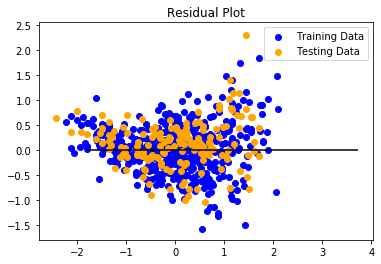

In [ ]:
# Make predictions using a fitted model
# Plot the difference between the model predicted values and actual y values, versus the model predicted values
# Hint: You can predict values of X training and testing data using the model.predict() method on a fitted model

### BEGIN SOLUTION
predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled, y_train_scaled)
plt.scatter(model.predict(X_train_scaled), y_train_scaled - model.predict(X_train_scaled), c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), y_test_scaled - model.predict(X_test_scaled), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Residual Plot")
plt.show()
### END SOLUTION

In [ ]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.22950241298678842, R2: 0.7942752523744798


In [ ]:
# LASSO model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.23077814864424268, R2: 0.7931316896870506


In [ ]:
# Ridge model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.22950315102692478, R2: 0.7942745907992098


In [ ]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 0.23023666224743816, R2: 0.7936170752255969
